To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://github.com/unslothai/unsloth?tab=readme-ov-file#-installation-instructions).

**[NEW] As of Novemeber 2024, Unsloth now supports vision finetuning!**

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)

**This notebook finetunes Llama 3.2 11B to assist medical professionals in analyzing xrays, CT scans & ultrasounds.**

In [1]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

* We support Llama 3.2 Vision 11B, 90B; Pixtral; Qwen2VL 2B, 7B, 72B; and any Llava variant like Llava NeXT!
* We support 16bit LoRA via `load_in_4bit=False` or 4bit QLoRA. Both are accelerated and use much less memory!

In [2]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.4.8: Fast Mllama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/385k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [3]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.vision_model.transformer` require gradients


In [4]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


<a name="Data"></a>
### Data Prep
We'll be using a sampled version of the ROCO radiography dataset. You can access the dataset [here](https://huggingface.co/datasets/unsloth/Radiology_mini). The full dataset is [here](https://huggingface.co/datasets/eltorio/ROCOv2-radiology).

The dataset includes X-rays, CT scans and ultrasounds showcasing medical conditions and diseases. Each image has a caption written by experts describing it. The goal is to finetune a VLM to make it a useful analysis tool for medical professionals.


In [5]:
from PIL import Image
import requests
from io import BytesIO
from datasets import Dataset
import pandas as pd
import csv

In [6]:
csv_file_path = "/content/drive/MyDrive/Database_climate.csv"
climate_data = pd.read_csv(csv_file_path, delimiter=",")

# Rename columns if necessary
if climate_data.columns[0] == "image_link;text":
    climate_data.columns = ["image_link", "caption"]

# Apply the conversion function

# Verify the result
print(climate_data.head())

   id                                               image  \
0    1  https://drive.google.com/file/d/1YCVksvcvsCPVT...   
1    2  https://drive.google.com/file/d/1uCa4GYzwVSsJn...   
2    3  https://drive.google.com/file/d/1V9-SxcDpaIMk-...   
3    4  https://drive.google.com/file/d/1k8XiPLuVQye5F...   
4    5  https://drive.google.com/file/d/1N20rbbwmkiAA-...   

                                             caption  
0  Map showing the climatology of near-surface ai...  
1  Map illustrating the climatology of latent tem...  
2  Climatological map of equivalent temperature (...  
3  Map of 2023 warm-season LSWT anomalies in Euro...  
4  Map of 2023 LSWT anomalies across African lake...  


Evaluation hallucination


In [7]:
print(climate_data.columns)

Index(['id ', 'image', 'caption'], dtype='object')


In [8]:
def convert_to_direct_download_link(view_link):
    """
    Converts a Google Drive view link to a direct download link, skipping already-converted links.
    """
    try:
        if pd.isna(view_link):  # Check for NaN or None
            return None
        # Skip if the link is already a direct download link
        if view_link.startswith("https://drive.google.com/uc?export=download&id="):
            return view_link
        # Convert if it's a Google Drive view link
        if "/file/d/" in view_link:
            file_id = view_link.split("/d/")[1].split("/view")[0]
            return f"https://drive.google.com/uc?export=download&id={file_id}"
        # Raise an error if it's not a valid Google Drive link
        raise ValueError("Invalid Google Drive link format")
    except Exception as e:
        print(f"Failed to convert link: {view_link} - {e}")
        return None

In [9]:
climate_data["image"] = climate_data["image"].apply(convert_to_direct_download_link)

In [10]:
def fetch_image_from_url(direct_link):
    try:
        # Fetch the image
        response = requests.get(direct_link, stream=True)
        response.raise_for_status()

        # Check content type
        if "image" not in response.headers.get("Content-Type", ""):
            raise ValueError("The fetched content is not an image")

        # Load the image
        image = Image.open(BytesIO(response.content)).convert("RGB")
        return image
    except Exception as e:
        print(f"Failed to fetch image from {direct_link}: {e}")
        return None

# Preprocess the dataset
def preprocess_function(row):
    image_url = row["image"]
    image = fetch_image_from_url(image_url)
    caption = row["caption"]
    return {"image": image, "caption": caption}

# Apply preprocessing to each row in the dataset
processed_data = []
for _, row in climate_data.iterrows():
    processed_row = preprocess_function(row)
    if processed_row["image"] is not None:  # Only include valid images
        processed_data.append(processed_row)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
print(climate_data.head())

   id                                               image  \
0    1  https://drive.google.com/uc?export=download&id...   
1    2  https://drive.google.com/uc?export=download&id...   
2    3  https://drive.google.com/uc?export=download&id...   
3    4  https://drive.google.com/uc?export=download&id...   
4    5  https://drive.google.com/uc?export=download&id...   

                                             caption  
0  Map showing the climatology of near-surface ai...  
1  Map illustrating the climatology of latent tem...  
2  Climatological map of equivalent temperature (...  
3  Map of 2023 warm-season LSWT anomalies in Euro...  
4  Map of 2023 LSWT anomalies across African lake...  


In [13]:
print(processed_data[:3])  # Inspect the first 3 rows

[{'image': <PIL.Image.Image image mode=RGB size=822x546 at 0x78EDFFB68050>, 'caption': 'Map showing the climatology of near-surface air temperature (Ta) from ERA5 for the period 1991–2020. Values are expressed in Kelvin (K). The pattern illustrates the familiar latitudinal gradient, with warmer temperatures in the tropics and cooler temperatures toward the poles.'}, {'image': <PIL.Image.Image image mode=RGB size=810x514 at 0x78EDEFE9E010>, 'caption': 'Map illustrating the climatology of latent temperature (Tq), defined as the difference between equivalent temperature (Teq) and air temperature (Ta), based on ERA5 data for 1991–2020. Tq highlights the contribution of latent heat, with strongest values in tropical regions due to high humidity and moisture content.'}, {'image': <PIL.Image.Image image mode=RGB size=832x560 at 0x78EDFF87B510>, 'caption': 'Climatological map of equivalent temperature (Teq) from ERA5 for the years 1991–2020. Teq combines sensible and latent heat to represent t

In [14]:
from datasets import Dataset, Features, Value, Image

# Define dataset features
features = Features({
    "image": Image(),  # Define the `image` column as an Image feature
    "caption": Value("string"),  # Define the `caption` column as a string
})

# Convert processed_data to a dictionary suitable for Hugging Face Dataset
hf_dataset = Dataset.from_dict({key: [item[key] for item in processed_data] for key in processed_data[0]}, features=features)

# Verify the dataset
print(hf_dataset)
print(hf_dataset[0])  # Inspect the first row

Dataset({
    features: ['image', 'caption'],
    num_rows: 289
})
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=822x546 at 0x78EDFED65190>, 'caption': 'Map showing the climatology of near-surface air temperature (Ta) from ERA5 for the period 1991–2020. Values are expressed in Kelvin (K). The pattern illustrates the familiar latitudinal gradient, with warmer temperatures in the tropics and cooler temperatures toward the poles.'}


In [15]:
def preprocess_function(sample):
    return {
        "image": sample["image"],  # Local path to the image
        "caption": sample["caption"],  # Corresponding caption/label
    }

hf_dataset = hf_dataset.map(preprocess_function)

# Split into train and validation datasets
split_dataset = hf_dataset.train_test_split(test_size=0.2)
train_dataset = split_dataset["train"]
valid_dataset = split_dataset["test"]

Map:   0%|          | 0/289 [00:00<?, ? examples/s]

Let's take a look at the dataset, and check what the 1st example shows:

In [16]:
hf_dataset

Dataset({
    features: ['image', 'caption'],
    num_rows: 289
})

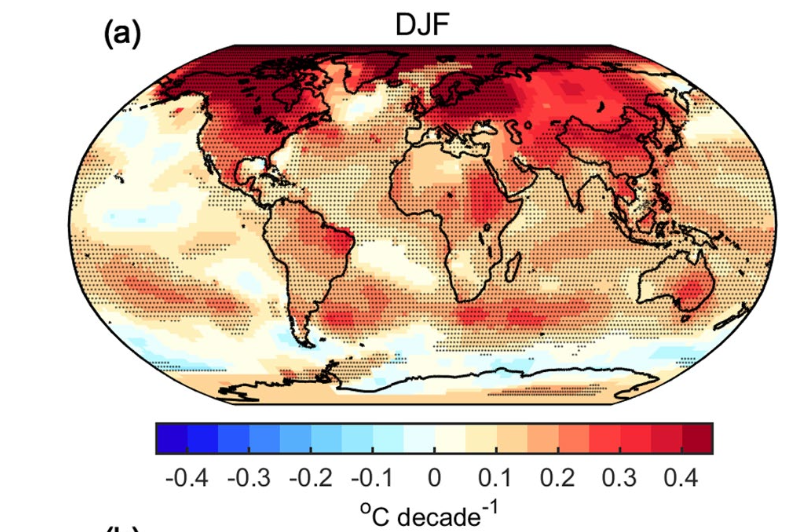

In [78]:
hf_dataset[176]["image"]

In [79]:
hf_dataset[176]["caption"]

'Linear trend of annual surface air temperature (units: °C \xad decade−1) during 1961–2014. The dotted regions represent correla- tions required for significance at the 95% level.'

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": instruction}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": answer} ]
},
]
```

We will craft an custom instruction asking the VLM to be an expert radiographer. Notice also instead of just 1 instruction, you can add multiple turns to make it a dynamic conversation.

In [19]:
instruction = "You are a climate expert. Please, explain what the image shows"

def convert_to_conversation(sample):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": sample["image"]},
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": sample["caption"]}],
        },
    ]
    return {"messages": conversation}

converted_dataset = hf_dataset.map(convert_to_conversation)

Map:   0%|          | 0/289 [00:00<?, ? examples/s]

Let's convert the dataset into the "correct" format for finetuning:

In [20]:
converted_dataset = [convert_to_conversation(sample) for sample in hf_dataset]

The first example is now structured like below:

In [21]:
converted_dataset[11]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'You are a climate expert. Please, explain what the image shows'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=976x712>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'SSTAs for boreal spring 2023 show the emergence of strong coastal El Niño conditions off South America with SSTAs exceeding +1.0°C to +2.0°C. These warming events signal a transition from La Niña to El Niño. The North Pacific remains largely warm, with some coastal cooling.'}]}]}

\Before we do any finetuning, maybe the vision model already knows how to

---

analyse the images? Let's check if this is the case!

In [22]:
from PIL import Image

# Enable the model for inference
FastVisionModel.for_inference(model)

# Load the image from the dataset
image = hf_dataset[61]["image"]  # This is already a PIL Image
image = image.convert("RGB")  # If needed, ensure it's in RGB mode

# Display or process the image
image.show()

# Instruction for the model
instruction = "You are climate analyst. Describe accurately what you can see in image."

# Construct messages for inference
messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]

# Prepare input text for the tokenizer
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

# Tokenize the input (process both image and text)
inputs = tokenizer(
    images=image,  # Pass the actual image object
    text=input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

# Generate predictions
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=128,
    use_cache=True,
    temperature=1.5,
    min_p=0.1,
)

The image depicts an anomaly map, displaying temperature variations over South Africa. The map, rotated ninety degrees anti-clockwise, exhibits the following temperature ranges:

**Colder-than-usual temperatures (dark blue through blue) are seen in the South-West, specifically within the Namibian region, but also observed in parts of South Africa's eastern and western coastal areas.**

**Unchanged temperatures (white) are common throughout South Africa, with a concentration around the Free State.**

**Warmer-than-usual temperatures (yellow through orange) are predominant in the Northern areas of South Africa, which could be attributed to the climate variability and/or


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [23]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 35,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [24]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
7.848 GB of memory reserved.


In [25]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 289 | Num Epochs = 1 | Total steps = 35
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 67,174,400/11,000,000,000 (0.61% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.813900
2,2.620300
3,2.779200
4,2.762900
5,2.173300
6,1.806600
7,1.898700
8,1.650900
9,1.726500
10,1.867700


In [26]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

2827.7608 seconds used for training.
47.13 minutes used for training.
Peak reserved memory = 10.777 GB.
Peak reserved memory for training = 2.929 GB.
Peak reserved memory % of max memory = 73.109 %.
Peak reserved memory for training % of max memory = 19.87 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [80]:
FastVisionModel.for_inference(model) # Enable for inference!

image = hf_dataset[176]["image"]  # This is already a PIL Image
image = image.convert("RGB")  # If needed, ensure it's in RGB mode

# Display or process the image
image.show()
instruction = "You are an expert climate analyst. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 512,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

Global mean trend of decadal warming during DJF from 1992 to 2012. The map highlights areas of significant warming in eastern North America, Western Europe, and parts of Australia.<|eot_id|>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [28]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

[]

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [65]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = False, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = hf_dataset[233]["image"]  # This is already a PIL Image
image = image.convert("RGB")  # If needed, ensure it's in RGB mode

# Display or process the image
image.show()
instruction = "You are an expert climate analyst. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 512,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

Average mortality rate ratios associated with temperature and humidity for males across Europe. Heat stress appears to have contributed to the elevated mortality during the summer of 2023, with Southern European countries like Cyprus and Greece being particularly affected.<|eot_id|>


[link text](https://)### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Llama 3.2 Conversational notebook. [Free Colab](https://colab.research.google.com/drive/1T5-zKWM_5OD21QHwXHiV9ixTRR7k3iB9?usp=sharing)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/drive/1WZDi7APtQ9VsvOrQSSC5DDtxq159j8iZ?usp=sharing)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/drive/1j0N4XTY1zXXy7mPAhOC1_gMYZ2F2EBlk?usp=sharing)
4. Qwen 2 VL Vision finetuning - Maths OCR to LaTeX. [Free Colab](https://colab.research.google.com/drive/1whHb54GNZMrNxIsi2wm2EY_-Pvo2QyKh?usp=sharing)
5. Pixtral 12B Vision finetuning - General QA datasets. [Free Colab](https://colab.research.google.com/drive/1K9ZrdwvZRE96qGkCq_e88FgV3MLnymQq?usp=sharing)
6. More notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [Github](https://github.com/unslothai/unsloth)!

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>